# Analyse bivariée: génération, genre, continent, champ scientifique principal

Pour l'importation des données, voir ces carnets sparqlbook:
* [Occupations](../../sparqlbooks/wdt_import_occupations.sparqlbook.md)
* [Field](../../sparqlbooks/wdt_import_fields.sparqlbook.md)
* [Continents](../../sparqlbooks/wdt_import_citizenships.sparqlbook.md)


Pour vérifier l'ensemble des informations disponibles, voir ce carnet sparqlbook:
* [Information disponible](../../sparqlbooks/wdt_available_information.sparqlbook.md )




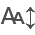

In [278]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)




In [279]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [280]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [281]:
## define SPARQL enpoint
endpoint = "https://ag15yee0az6rmk64.allegrograph.cloud/repositories/ceos"

In [282]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) 
            ( GROUP_CONCAT(DISTINCT ?genderLabel; separator=", ") AS ?genders ) 
            ( GROUP_CONCAT(DISTINCT ?countryLabel; separator=", ") AS ?countries )
            ( GROUP_CONCAT(DISTINCT ?continentLabel; separator=", ") AS ?continents )
            ( GROUP_CONCAT(DISTINCT ?occupationLabel; separator=", ") AS ?occupations )
            ( GROUP_CONCAT(DISTINCT ?fieldLabel; separator=", ") AS ?fields )
WHERE {
    GRAPH <https://github.com/Laillaa/French_CEOs/blob/main/graphs/Wikidata-imported-data.md>
        {?s wdt:P21 ?gender;
            rdfs:label ?label;
            wdt:P569 ?birthDate;
            wdt:P27 ?country.
        ?gender rdfs:label ?genderLabel.
        ?country rdfs:label ?countryLabel.
        ?country wdt:P30 ?continent.
        ?continent rdfs:label ?continentLabel.
        OPTIONAL {  ?s wdt:P106 ?occupation.
                    ?occupation rdfs:label ?occupationLabel.}
        OPTIONAL {  ?s wdt:P101 ?field.
                    ?field rdfs:label ?fieldLabel.}

        ## Excluding Australia and Oceania insular
        # Eurasia : wd:Q5401 
        FILTER ( ?continent NOT IN ( wd:Q3960, wd:Q538))
          }
}
GROUP BY ?s
"""

In [283]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [284]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

2555


[['http://www.wikidata.org/entity/Q7151785',
  'Paul King',
  '1984',
  'male',
  'United States',
  'North America',
  'chief executive officer, entrepreneur',
  ''],
 ['http://www.wikidata.org/entity/Q562917',
  'Steve Case',
  '1958',
  'male',
  'United States',
  'North America',
  'chief executive officer, businessperson',
  ''],
 ['http://www.wikidata.org/entity/Q12316216',
  'Henning Axel Nielsen',
  '1938',
  'male',
  'Kingdom of Denmark',
  'Europe',
  'chief executive officer, businessperson',
  '']]

In [285]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'gender', 'countries', 'continents', 'occupations', 'fields']
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer,
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson",


In [286]:
## transformer les années en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [287]:
### Inspecter la structure du dataframe
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2555 entries, 0 to 2554
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    2555 non-null   object
 1   personLabel  2555 non-null   object
 2   birthYear    2555 non-null   int64 
 3   gender       2555 non-null   object
 4   countries    2555 non-null   object
 5   continents   2555 non-null   object
 6   occupations  2555 non-null   object
 7   fields       2555 non-null   object
dtypes: int64(1), object(7)
memory usage: 159.8+ KB


In [288]:
### Store to CSV
f_path = '../df_continent_occupations_fields_20250406.csv'
df_p.to_csv(f_path)

## Coder les continents et afficher leur distribution

In [289]:
### Inspecter les données
print(df_p.iloc[ :5 , :].continents)

0    North America
1    North America
2           Europe
3    North America
4           Africa
Name: continents, dtype: object


In [290]:
### Regrouper et compter
df_contCode = df_p.groupby('continents').size()
df_contCode.columns=['effectif']
df_contCode = pd.DataFrame(df_contCode.sort_values( ascending = False))
#df_contCode.reset_index(inplace=True)
print(df_contCode.head(10))



                          0
continents                 
Europe                 1114
Asia                    643
North America           501
Africa                  105
Oceania                  66
South America            47
Europe, Asia             18
Asia, Europe             15
Europe, North America    10
North America, Asia       6


In [291]:
### Créer une fonction de codage
def codeContinents(continents):
    
    if 'Europe, Asia' in continents:
        output = 'Eurasia'    
    elif 'Europe' in continents:
        output = 'Europe'
    elif 'Africa' in continents:
        output = 'Africa'
    elif 'Oceania' in continents:
        output = 'Oceania'
    ## Issue with Russia, Russian Empire, Wikidata not consistent    
    elif 'Eurasia' in continents:
        output = 'Eurasia'
    elif 'North America' in continents:
        output = 'NorthAmerica'   
    elif 'Asia' in continents:
        output = 'Asia'
    elif 'South America' in continents:
        output = 'SouthAmerica' 
    else:
        output = 'Missing'                 
    return output    

In [292]:
### Tester la fonction
print(codeContinents('Oceania, North America, Africa'))

Africa


In [293]:
### On ajoute une nouvelle colonne 'contCode' et y on met pour chaque ligne le résultat de la fonction
df_p['contCode'] = df_p.apply(lambda x: codeContinents(x['continents']), axis=1)
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe


In [294]:


### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



              effectif
contCode              
Eurasia             20
SouthAmerica        47
Oceania             69
Africa             109
NorthAmerica       510
Asia               643
Europe            1157


In [295]:
### How to handle data about Russians
df_p[df_p.countries.str.contains('Russi')].head(7)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
53,http://www.wikidata.org/entity/Q366524,Nikolai Ryzhkov,1929,male,Russia,Europe,"engineer, politician, statesperson, chief exec...","politics, welding, politician, heavy machine b...",Europe
77,http://www.wikidata.org/entity/Q4223722,Valentin Klimov,1939,male,"Russia, Soviet Union","Europe, Asia","scientist, inventor, chief executive officer, ...","aeronautical engineering, aircraft constructio...",Eurasia
102,http://www.wikidata.org/entity/Q47453276,Aleksandr Inozemtsev,1951,male,"Russia, Soviet Union","Europe, Asia","scientist, inventor, chief executive officer, ...","aeronautical engineering, aircraft constructio...",Eurasia
103,http://www.wikidata.org/entity/Q104760616,Valentin Sushko,1932,male,"Russia, United States, Soviet Union","Europe, North America, Asia","chief executive officer, statesperson",,Europe
130,http://www.wikidata.org/entity/Q124035147,Yury Klishin,1947,male,"Soviet Union, Russia","Europe, Asia","aircraft pilot, chief executive officer, milit...",,Eurasia
185,http://www.wikidata.org/entity/Q21559001,Izrail Levin,1908,male,"Russian Empire, Russia, Soviet Union","Eurasia, North America, Europe, Asia","non-fiction writer, industrialist, chief execu...",,Eurasia
232,http://www.wikidata.org/entity/Q18634567,Nikolay Maksimov,1911,male,"Russian Empire, Soviet Union","North America, Eurasia, Asia, Europe",chief executive officer,,Europe


In [296]:
 
### Regrouper et compter les personnes issues de Russie
df_contCode = df_p[df_p.countries.str.contains('ussi')].groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']
print(df_contCode)



          effectif
contCode          
Eurasia         12
Europe          23


In [297]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p.iloc[ 97:101 , : ]

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode
97,http://www.wikidata.org/entity/Q8421760,Jay Walder,1958,male,United States,North America,chief executive officer,,NorthAmerica
98,http://www.wikidata.org/entity/Q107749830,Udi Adiri,1977,male,Israel,Asia,chief executive officer,,Asia
99,http://www.wikidata.org/entity/Q16105139,David Komansky,1939,male,United States,North America,"business executive, chief executive officer, c...",,NorthAmerica
100,http://www.wikidata.org/entity/Q12411844,Simcha Even-Zohar,1905,male,Israel,Asia,chief executive officer,,Asia


### Distribution des continents: représentation graphique

In [298]:
### Regrouper et compter
df_contCode = df_p.groupby('contCode').size()
df_contCode = pd.DataFrame(df_contCode.sort_values(ascending = True))
#df_contCode.reset_index(inplace=True)
df_contCode.columns=['effectif']

df_contCode['frequence'] = (100 * df_contCode['effectif'] \
                                   / df_contCode['effectif'].sum()).round(2)
df_contCode



,effectif,frequence
contCode,,
Eurasia,20,0.78
SouthAmerica,47,1.84
Oceania,69,2.70
Africa,109,4.27
NorthAmerica,510,19.96
Asia,643,25.17
Europe,1157,45.28


In [299]:

ljt = pd.DataFrame(df_contCode['frequence'].sort_values(ascending=False)).T
ljt



contCode,Europe,Asia,NorthAmerica,Africa,Oceania,SouthAmerica,Eurasia
frequence,45.28,25.17,19.96,4.27,2.7,1.84,0.78


In [300]:
### Définir les couleurs en fonction des continents
# Noter que cette liste des couleurs et continents
# doit être adaptée à l'ordre de tri des données 
# dans le graphique
col_palette = [
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral: Asia
    "#F6E58D",  # Light Yellow :SouthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#E3D4AD",  # Desert Sand : Eurasia
    "#A3C1DA",  # Light Blue : Africa    

]


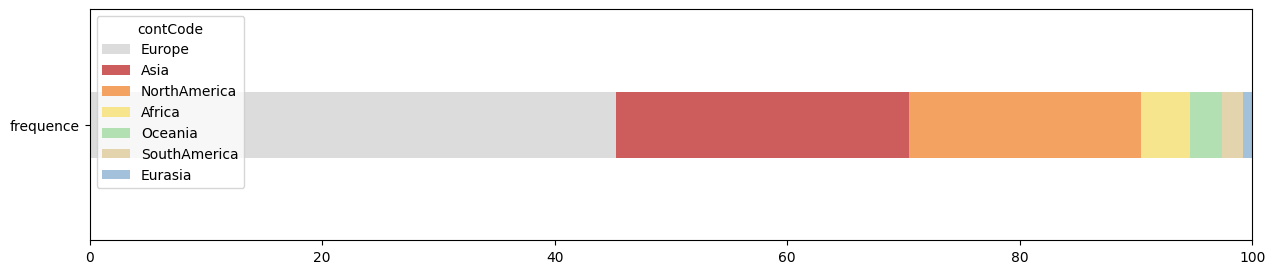

In [301]:


### Pandas plot reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
## Barplots
# https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

fig = ljt.plot(kind='barh', stacked=True, figsize=(15,3), color=col_palette, width=0.2, xlim=[0,100])

### Codage par période de vingt-cinq ans

In [302]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1751, 2025, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1901, 1926, 1951, 1976, 2001] 10


In [303]:
### Transformer les années de naissance en entiers
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [304]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_p['per_25'] = pd.cut(df_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['per_25'] = df_p['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe,1926-1950


In [305]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25', observed=True).size()
print(naissances_per)

per_25
1751-1775       1
1776-1800       2
1801-1825       6
1826-1850      12
1851-1875      30
1876-1900      74
1901-1925     143
1926-1950     443
1951-1975    1390
1976-2000     454
dtype: int64


### Comparer période et continent

In [306]:


### Tableau de contingence
X = "contCode"
Y = "per_25"  # "0"

ddf = df_p[[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,0,0,0,1,0,0,0,1
1776-1800,0,0,0,2,0,0,0,2
1801-1825,0,0,0,6,0,0,0,6
1826-1850,0,0,0,11,0,1,0,12
1851-1875,0,0,0,25,4,1,0,30
1876-1900,0,7,1,58,6,2,0,74
1901-1925,0,41,6,75,19,2,0,143
1926-1950,9,173,6,130,97,22,6,443
1951-1975,49,325,5,660,289,31,31,1390


In [307]:
### Modifiy column order
print(ddf.columns.to_list())
ddf = ddf[['Europe', 'Eurasia',  'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica', 'Total']]
ddf

['Africa', 'Asia', 'Eurasia', 'Europe', 'NorthAmerica', 'Oceania', 'SouthAmerica', 'Total']


contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica,Total
per_25,,,,,,,,
1751-1775,1,0,0,0,0,0,0,1
1776-1800,2,0,0,0,0,0,0,2
1801-1825,6,0,0,0,0,0,0,6
1826-1850,11,0,0,0,0,1,0,12
1851-1875,25,0,4,0,0,1,0,30
1876-1900,58,1,6,7,0,2,0,74
1901-1925,75,6,19,41,0,2,0,143
1926-1950,130,6,97,173,9,22,6,443
1951-1975,660,5,289,325,49,31,31,1390


In [308]:
### Adapter à l'ordre des colonnes
col_palette_1 = [
    "#DCDCDC",  # Gainsboro : Europe
    "#E3D4AD",  # Desert Sand : Eurasia
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#F4A261",  # Light Coral : Asia
    "#A3C1DA",  # Light Blue : Africa
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


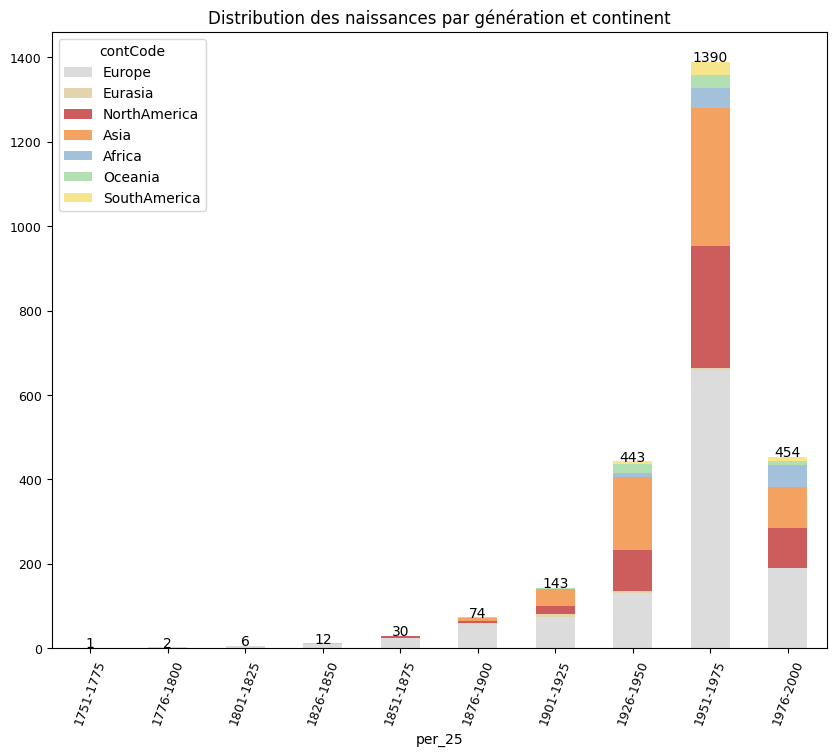

In [309]:
### Représenter l'évolution de la distribution dans le temps par continent
#  Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

data = ddf.iloc[:-1,:-1]

ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8), color=col_palette_1)
plt.title('Distribution des naissances par génération et continent')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
for x, y in enumerate(data.sum(axis=1)):
    ax.annotate(y, (x, y+0.1), ha='center') 

plt.show()

## Analyse bivariée: périodes, continents



On observe un fort déséquilibre entre les périodes et les continents. On peut présenter ce fait, par exemple en relevant le développement des États Unis et de la Russie (Eurasie) dès le milieu du 19e siècle. Mais on ne peut pas utiliser les données comme telles pour une analyse, il faudra restreindre l'analyse à la partie du tableau pour laquelle les effectis sont suffisants.



In [310]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddf.iloc[3:10,:-1].copy(deep=True)
D



contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,11,0,0,0,0,1,0
1851-1875,25,0,4,0,0,1,0
1876-1900,58,1,6,7,0,2,0
1901-1925,75,6,19,41,0,2,0
1926-1950,130,6,97,173,9,22,6
1951-1975,660,5,289,325,49,31,31
1976-2000,189,2,95,97,51,10,10


In [311]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 7 , 7 ), effectif: 2546 , nombre max. facteurs: 6


In [312]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 248.3 , dof : 36
p-value : 1.5515052559606397e-33
phi2 = inertie (variance totale) : 0.0975274932139134
Cramer:  0.12749345944917684


In [313]:
### Situation à l'indépendance

indep = pd.DataFrame(expected)
indep.columns = D.columns
indep.index = D.index
indep.round(0).astype(int)

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,5,0,2,3,1,0,0
1851-1875,14,0,6,8,1,1,1
1876-1900,33,1,15,19,3,2,1
1901-1925,64,1,29,36,6,4,3
1926-1950,200,3,89,112,19,12,8
1951-1975,627,11,278,351,60,38,26
1976-2000,205,4,91,115,19,12,8


In [314]:
### Écart à l'indépendance:
# différence en effectifs entre le théorique et l'observé
#  Valeurs arrondies
### Doc. :
#   Bennani, p.30
#  https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
ecarts = (D-indep)
## Attention : arrondi aux entiers dans l'affichage
print(ecarts.round(0).astype(int))

contCode   Europe  Eurasia  NorthAmerica  Asia  Africa  Oceania  SouthAmerica
per_25                                                                       
1826-1850       6        0            -2    -3      -1        1             0
1851-1875      11        0            -2    -8      -1        0            -1
1876-1900      25        0            -9   -12      -3        0            -1
1901-1925      11        5           -10     5      -6       -2            -3
1926-1950     -70        3             8    61     -10       10            -2
1951-1975      33       -6            11   -26     -11       -7             5
1976-2000     -16       -2             4   -18      32       -2             2


In [315]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
residus_ponderes

contCode,Europe,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,,
1826-1850,2.40,-0.31,-1.55,-1.74,-0.72,1.18,-0.47
1851-1875,3.12,-0.49,-0.82,-2.75,-1.13,0.21,-0.74
1876-1900,4.26,0.55,-2.29,-2.70,-1.78,-0.00,-1.17
1901-1925,1.31,4.60,-1.80,0.81,-2.47,-0.95,-1.62
1926-1950,-4.94,1.35,0.88,5.78,-2.29,2.88,-0.76
1951-1975,1.33,-1.79,0.63,-1.39,-1.36,-1.09,1.05
1976-2000,-1.10,-0.83,0.43,-1.65,7.16,-0.66,0.56


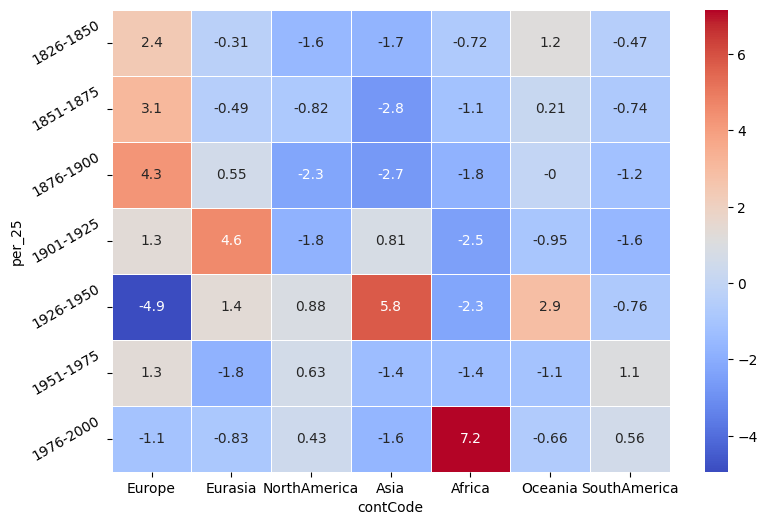

In [316]:
### Résidus pondérés
tableau = residus_ponderes

fig, ax = plt.subplots(figsize=(9,6))         
# Sample figsize in inches
g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
labels = tableau.index
p = g.set_yticklabels(labels, rotation=30)

plt.show()



### En excluant l'Europe ou choisissant les pays

In [317]:
print(D.columns.to_list())
D.iloc[ : , 1:]

['Europe', 'Eurasia', 'NorthAmerica', 'Asia', 'Africa', 'Oceania', 'SouthAmerica']


contCode,Eurasia,NorthAmerica,Asia,Africa,Oceania,SouthAmerica
per_25,,,,,,
1826-1850,0,0,0,0,1,0
1851-1875,0,4,0,0,1,0
1876-1900,1,6,7,0,2,0
1901-1925,6,19,41,0,2,0
1926-1950,6,97,173,9,22,6
1951-1975,5,289,325,49,31,31
1976-2000,2,95,97,51,10,10


In [318]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D.iloc[ : , 1:])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D.iloc[ : , 1:], method='cramer')
print('Cramer: ', vc)

Chi2 : 155.23 , dof : 30
p-value : 7.876699594530073e-19
phi2 = inertie (variance totale) : 0.06096940306477932
Cramer:  0.1490206945729534


In [319]:
D[['Europe', 'Asia', 'Eurasia', 'NorthAmerica', 'SouthAmerica']]

contCode,Europe,Asia,Eurasia,NorthAmerica,SouthAmerica
per_25,,,,,
1826-1850,11,0,0,0,0
1851-1875,25,0,0,4,0
1876-1900,58,7,1,6,0
1901-1925,75,41,6,19,0
1926-1950,130,173,6,97,6
1951-1975,660,325,5,289,31
1976-2000,189,97,2,95,10


In [320]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D[['Europe', 'Eurasia']])

print('Chi2 :', statistic.round(2), ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D[['Europe', 'Eurasia']], method='cramer')
print('Cramer: ', vc)

Chi2 : 26.27 , dof : 6
p-value : 0.00019805471576253079
phi2 = inertie (variance totale) : 0.01031917061897002
Cramer:  0.14997890375592896


## Continent et genre

In [321]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe,1926-1950
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer,,NorthAmerica,1926-1950
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson",,Africa,1951-1975


In [322]:


### Tableau de contingence
X = "contCode"
Y = "gender"  # "0"

ddgc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgc



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
gender,,,,,,,,
female,42,100,1,216,85,18,6,468
male,67,543,19,941,425,51,41,2087
Total,109,643,20,1157,510,69,47,2555


### Créer la fonction

In [323]:
def bivariee_stats(D):
    ### Valeurs produites par la fonction de la librairie 'stats'
    statistic, p, dof, expected = stats.chi2_contingency(D)

    print('Chi2 :', statistic.round(2), ', dof :',dof)
    print('p-value :', p)


    print('phi2 = inertie (variance totale) :', statistic/n)


    ### Tableau à l'indépendance
    dfe = round(pd.DataFrame(expected),4)

    ### Coéfficient de Cramer
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

    vc = stats.contingency.association(D, method='cramer')
    print('Cramer: ', vc)

    ### Situation à l'indépendance
    indep = pd.DataFrame(expected)
    indep.columns = D.columns
    indep.index = D.index

    ### Résidus pondérés (avec le signe)
    ### Doc. :
    #   Rakotomalala, p.240
    residus_ponderes = (round((D-indep)/np.sqrt(indep),2))
    ### Résidus pondérés
    tableau = residus_ponderes
    
    fig, ax = plt.subplots(figsize=(9,3))         
    # Sample figsize in inches
    g = sns.heatmap(tableau, annot=tableau, cmap="coolwarm", linewidths=.5, ax=ax)
    xlabels = tableau.columns
    px = g.set_xticklabels(xlabels, rotation=60, size=8, 
                           ha='right', rotation_mode='anchor')
    ylabels = tableau.index
    #py = g.set_yticklabels(ylabels, rotation=20, size=8)
    g.set_yticklabels(g.get_yticklabels(), rotation=20, size=8)
    plt.show()
    

In [324]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = ddgc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
gender,,,,,,,
female,42,100,1,216,85,18,6
male,67,543,19,941,425,51,41


Chi2 : 40.2 , dof : 6
p-value : 4.1548752709087017e-07
phi2 = inertie (variance totale) : 0.015790736689851977
Cramer:  0.12543968169047578


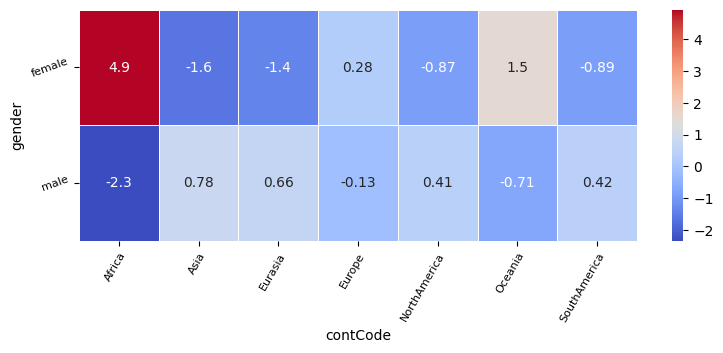

In [325]:
bivariee_stats(D)

### Genre et continent par époque

In [326]:
df_p['genre_cont'] = df_p.apply(lambda x: x.contCode + '_' + x.gender, axis=1)
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000,NorthAmerica_male
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975,NorthAmerica_male
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe,1926-1950,Europe_male
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer,,NorthAmerica,1926-1950,NorthAmerica_male
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson",,Africa,1951-1975,Africa_male


In [327]:
### Tableau de contingence
X = "genre_cont"
Y = "per_25"  # "0"

ddgcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddgcp

genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male,Total
per_25,,,,,,,,,,,,,,,
1751-1775,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1776-1800,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2
1801-1825,0,0,0,0,0,0,0,6,0,0,0,0,0,0,6
1826-1850,0,0,0,0,0,0,1,10,0,0,0,1,0,0,12
1851-1875,0,0,0,0,0,0,1,24,0,4,0,1,0,0,30
1876-1900,0,0,0,7,0,1,6,52,1,5,0,2,0,0,74
1901-1925,0,0,1,40,0,6,6,69,1,18,0,2,0,0,143
1926-1950,0,9,15,158,0,6,10,120,10,87,4,18,3,3,443
1951-1975,20,29,67,258,0,5,139,521,51,238,9,22,1,30,1390


In [328]:
### Limiter à la période significative, 20 siècle
D = ddgcp.iloc[6:-1,:-1].copy(deep=True)
D


genre_cont,Africa_female,Africa_male,Asia_female,Asia_male,Eurasia_female,Eurasia_male,Europe_female,Europe_male,NorthAmerica_female,NorthAmerica_male,Oceania_female,Oceania_male,SouthAmerica_female,SouthAmerica_male
per_25,,,,,,,,,,,,,,
1901-1925,0,0,1,40,0,6,6,69,1,18,0,2,0,0
1926-1950,0,9,15,158,0,6,10,120,10,87,4,18,3,3
1951-1975,20,29,67,258,0,5,139,521,51,238,9,22,1,30
1976-2000,22,29,17,80,1,1,53,136,22,73,5,5,2,8


Chi2 : 249.64 , dof : 39
p-value : 1.5817916589724798e-32
phi2 = inertie (variance totale) : 0.09805096403913802
Cramer:  0.1850509715283878


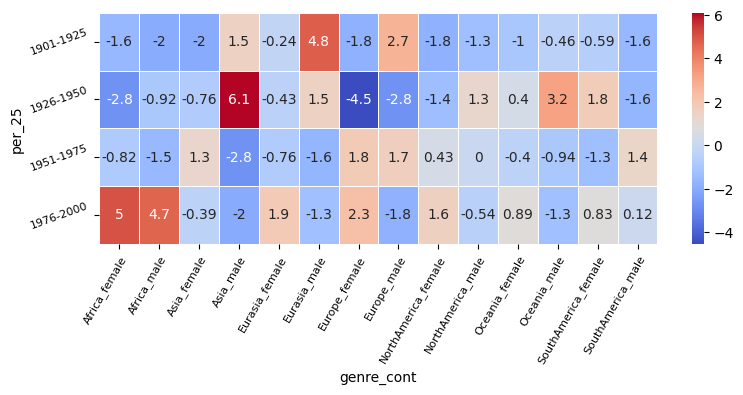

In [329]:
## Appliquer la fonction
bivariee_stats(D)

#### Explorer les résultats et commenter

In [330]:
df_pef = df_p[df_p['genre_cont'] == 'Europe_female']
print(len(df_pef))

216


In [331]:
print(df_pef.groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France                        40
Finland                       28
Spain                         24
United Kingdom                22
Norway                        21
Sweden                        20
Kingdom of the Netherlands    12
Kingdom of Denmark             8
Germany                        7
Austria                        3
dtype: int64


In [332]:
print(df_pef[df_pef.per_25 == '1976-2000'].groupby(by='countries', observed=True).size().sort_values(ascending=False).head(10))

countries
France                    15
Spain                      7
Germany                    4
Sweden                     3
Kingdom of Denmark         3
Finland                    3
United Kingdom             3
Cyprus                     1
Albania, United States     1
Belgium                    1
dtype: int64


In [333]:
fff = df_pef[(df_pef.per_25 == '1976-2000') & (df_pef.countries.str.contains('Germany'))]
print(len(fff))
fff.head()

4


,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
1309,http://www.wikidata.org/entity/Q124439575,Annette Mann,1977,female,Germany,Europe,"businessperson, chief executive officer",,Europe,1976-2000,Europe_female
2021,http://www.wikidata.org/entity/Q126916878,Anne Lamp,1991,female,Germany,Europe,chief executive officer,,Europe,1976-2000,Europe_female
2300,http://www.wikidata.org/entity/Q131004360,Friederike Driftmann,1991,female,Germany,Europe,"chief executive officer, jurist",,Europe,1976-2000,Europe_female
2528,http://www.wikidata.org/entity/Q58905354,Julia Bösch,1984,female,Germany,Europe,chief executive officer,,Europe,1976-2000,Europe_female


## Continent et Occupation principale

In [334]:
df_p.head()

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,genre_cont
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000,NorthAmerica_male
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975,NorthAmerica_male
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe,1926-1950,Europe_male
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer,,NorthAmerica,1926-1950,NorthAmerica_male
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson",,Africa,1951-1975,Africa_male


In [335]:
# Split the 'occupations' column into a list, stripping whitespace
df_p['occupations_list'] = df_p['occupations'].apply(lambda x: [i.strip() for i in x.split(',')] if pd.notnull(x) else [])

# Create 12 occupation columns (occupation1 to occupation12)
for i in range(12):
    df_p[f'occupation{i+1}'] = df_p['occupations_list'].apply(lambda x: x[i] if len(x) > i else None)

# Example: show the first 12 occupation columns for the first few rows
df_p[[f'occupation{i+1}' for i in range(12)]].head()

# Fill NaN values with None
for i in range(12):
    df_p[f'occupation{i+1}'] = df_p[f'occupation{i+1}'].fillna('None')

# delete the occupations_list column
df_p.drop(columns=['occupations_list'], inplace=True)

# Replace occupation1 with Main Occupation
df_p.rename(columns={'occupation1': 'Main Occupation'}, inplace=True) # Main Occupation represents the first occupation in the occupation column

In [336]:
df_p

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,...,occupation3,occupation4,occupation5,occupation6,occupation7,occupation8,occupation9,occupation10,occupation11,occupation12
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000,...,None,None,None,None,None,None,None,None,None,None
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975,...,None,None,None,None,None,None,None,None,None,None
2,http://www.wikidata.org/entity/Q12316216,Henning Axel Nielsen,1938,male,Kingdom of Denmark,Europe,"chief executive officer, businessperson",,Europe,1926-1950,...,None,None,None,None,None,None,None,None,None,None
3,http://www.wikidata.org/entity/Q17052234,Stephen Siegel,1944,male,United States,North America,chief executive officer,,NorthAmerica,1926-1950,...,None,None,None,None,None,None,None,None,None,None
4,http://www.wikidata.org/entity/Q2898568,Bernard Sabrier,1953,male,Morocco,Africa,"chief executive officer, businessperson",,Africa,1951-1975,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,http://www.wikidata.org/entity/Q6832621,Michael McCain,1958,male,Canada,North America,"chief executive officer, business executive","business, food manufacturing",NorthAmerica,1951-1975,...,None,None,None,None,None,None,None,None,None,None
2551,http://www.wikidata.org/entity/Q33112797,Barnabé Wayser,1981,male,France,Europe,"chief executive officer, entrepreneur, busines...",,Europe,1976-2000,...,businessperson,None,None,None,None,None,None,None,None,None
2552,http://www.wikidata.org/entity/Q332226,Lorenzo Zambrano,1944,male,Mexico,North America,"chief executive officer, businessperson",,NorthAmerica,1926-1950,...,None,None,None,None,None,None,None,None,None,None
2553,http://www.wikidata.org/entity/Q911897,David Dillon,1951,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975,...,None,None,None,None,None,None,None,None,None,None


In [353]:
# groupby each occupation column and count the occurrences
occupation_counts = df_p.groupby('Main Occupation').size().reset_index(name='count')
# sort the counts in descending order
occupation_counts = occupation_counts.sort_values(by='count', ascending=False)
occupation_counts


,Main Occupation,count
31,chief executive officer,1616
67,manager,245
26,businessperson,137
24,business executive,66
62,journalist,31
...,...,...
117,telecommunications engineering,1
124,veterinarian,1
122,trader,1
127,visual artist,1


C:\Users\laila\AppData\Local\Temp\ipykernel_14408\3481210541.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='Main Occupation', data=occupation_counts.head(10), palette='viridis')


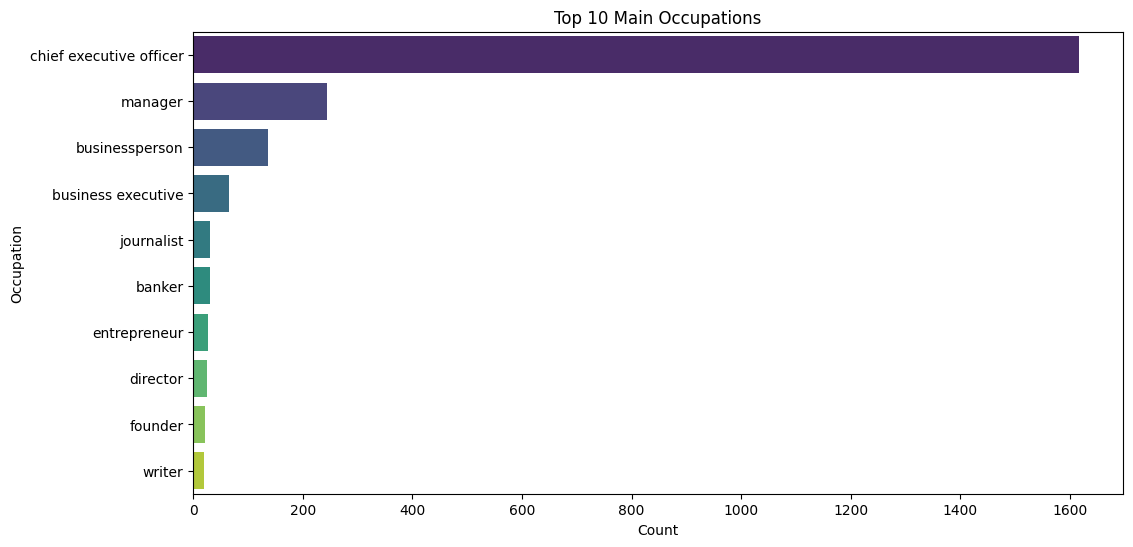

In [355]:
# Create a bar plot for the top 10 occupations
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='Main Occupation', data=occupation_counts.head(10), palette='viridis')
plt.title('Top 10 Main Occupations')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

In [338]:
### Tableau de contingence
X = "contCode"
Y = "Main Occupation"  # "0"

dddc = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
dddc

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
Main Occupation,,,,,,,,
Christian minister,0,0,0,0,1,0,0,1
New York Law School,1,0,0,0,0,0,0,1
Wikimedian,1,0,0,0,0,0,0,1
academic,0,2,0,0,0,1,0,3
academic administrator,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...
video game developer,0,0,0,0,1,0,0,1
visual artist,0,0,0,0,1,0,0,1
women's rights activist,0,0,0,0,1,0,1,2


In [339]:
### Profils des lignes
# axis=0 pour les colonnes

dddc_pl = dddc.apply(lambda x: (x/sum(x)*100*2).round(1), axis=1) 
dddc_pl

contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica,Total
Main Occupation,,,,,,,,
Christian minister,0.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
New York Law School,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
Wikimedian,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
academic,0.0,66.7,0.0,0.0,0.0,33.3,0.0,100.0
academic administrator,0.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...
video game developer,0.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
visual artist,0.0,0.0,0.0,0.0,100.0,0.0,0.0,100.0
women's rights activist,0.0,0.0,0.0,0.0,50.0,0.0,50.0,100.0


In [340]:
### Adapter à l'ordre des colonnes
col_palette_2 = [
    "#A3C1DA",  # Light Blue : Africa
    "#F4A261",  # Light Coral : Asia
    "#E3D4AD",  # Desert Sand : Eurasia
    "#DCDCDC",  # Gainsboro : Europe
    "#cd5c5c",  # Indian Red : NorthAmerica
    "#B2E0B2",  # Light Green : Oceania
    "#F6E58D",  # Light Yellow : SouthAmerica
    
]


In [341]:
### Production du tableau à analyser
## Noter que pour que l'analyse soit significative en 
# termes de Chi-2 il faudrait partir de la ligne quatre
# Aussi, la dernière ligne est probablement incomplète
# en termes de génération
D = dddc.iloc[:-1,:-1].copy(deep=True)
D



contCode,Africa,Asia,Eurasia,Europe,NorthAmerica,Oceania,SouthAmerica
Main Occupation,,,,,,,
Christian minister,0,0,0,0,1,0,0
New York Law School,1,0,0,0,0,0,0
Wikimedian,1,0,0,0,0,0,0
academic,0,2,0,0,0,1,0
academic administrator,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
vice president,0,0,0,2,0,0,0
video game developer,0,0,0,0,1,0,0
visual artist,0,0,0,0,1,0,0


Chi2 : 1765.1 , dof : 774
p-value : 3.4656044630831514e-79
phi2 = inertie (variance totale) : 0.6932855018143502
Cramer:  0.33932369016481434


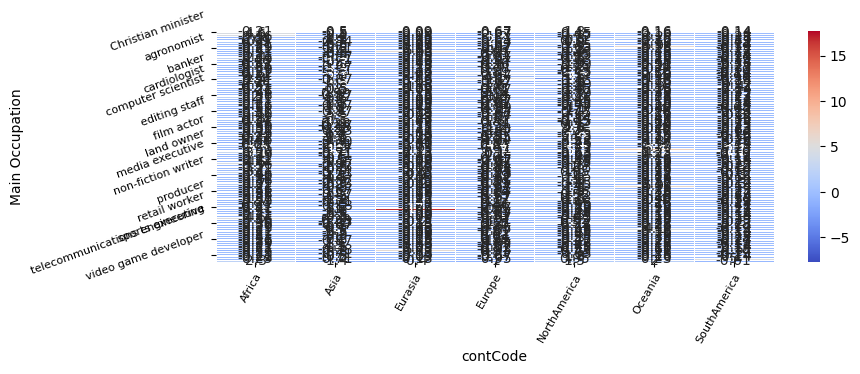

In [342]:
## Appliquer la fonction
bivariee_stats(D)

## Discipline et continent par époque

In [343]:
df_p.head(2)

,personUri,personLabel,birthYear,gender,countries,continents,occupations,fields,contCode,per_25,...,occupation3,occupation4,occupation5,occupation6,occupation7,occupation8,occupation9,occupation10,occupation11,occupation12
0,http://www.wikidata.org/entity/Q7151785,Paul King,1984,male,United States,North America,"chief executive officer, entrepreneur",,NorthAmerica,1976-2000,...,None,None,None,None,None,None,None,None,None,None
1,http://www.wikidata.org/entity/Q562917,Steve Case,1958,male,United States,North America,"chief executive officer, businessperson",,NorthAmerica,1951-1975,...,None,None,None,None,None,None,None,None,None,None


In [344]:
### Tableau de contingence
X = "Main Occupation"
Y = "per_25"  # "0"

dddcp = df_p[df_p.gender.isin(['female', 'male'])][[X,Y]].pivot_table(index=Y,columns=X,observed=True, aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int).T
dddcp

per_25,1751-1775,1776-1800,1801-1825,1826-1850,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,1976-2000,Total
Main Occupation,,,,,,,,,,,
Christian minister,0,0,0,0,0,0,0,0,1,0,1
New York Law School,0,0,0,0,0,0,0,0,1,0,1
Wikimedian,0,0,0,0,0,0,0,0,0,1,1
academic,0,0,0,0,0,0,0,0,2,1,3
academic administrator,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
video game developer,0,0,0,0,0,0,0,0,1,0,1
visual artist,0,0,0,0,0,0,0,0,0,1,1
women's rights activist,0,0,0,0,0,0,0,2,0,0,2


In [345]:
### Limiter à la période significative, 20 siècle
D = dddcp.iloc[5:-1,:-1].copy(deep=True)
D


per_25,1751-1775,1776-1800,1801-1825,1826-1850,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,1976-2000
Main Occupation,,,,,,,,,,
activist,0,0,0,0,0,0,2,2,9,6
actor,0,0,0,0,0,0,1,2,1,5
administrator,0,0,0,0,0,0,0,1,0,0
advertising person,0,0,0,0,0,0,0,0,1,0
agronomist,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
vice president,0,0,0,0,0,0,0,0,2,0
video game developer,0,0,0,0,0,0,0,0,1,0
visual artist,0,0,0,0,0,0,0,0,0,1


Chi2 : 1485.68 , dof : 1116
p-value : 5.766850988191368e-13
phi2 = inertie (variance totale) : 0.5835356641883506
Cramer:  0.25453173343199104


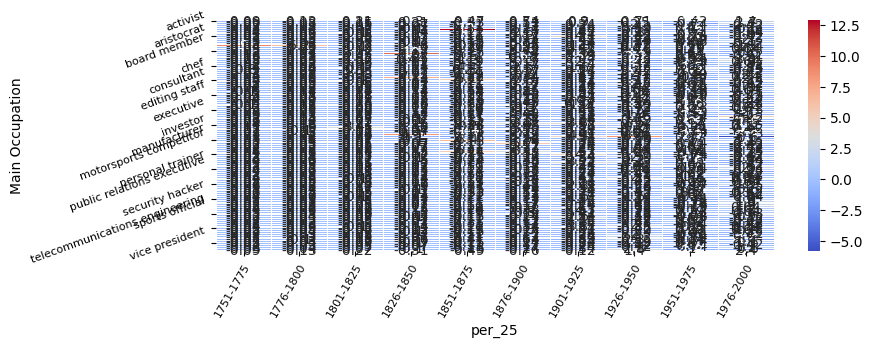

In [346]:
## Appliquer la fonction
bivariee_stats(D)